In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from prophet import Prophet
from functions_anton.functions_models import plot_forecast, step_modification_to_forecast

In [2]:
df_train = pd.read_parquet('parquet_4_testing/train_01.parquet')
df_test = pd.read_parquet('parquet_4_testing/test_01.parquet')

In [3]:
forecast_freq = 5 # minutes, dicretization between individual values of the forcast
forecast_days = 7 # how many days should be forecasted
train_days = 30 # how many days will be used to train on
sampling_rate = 5 #in minutes, very important parameter

train_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = train_days)
train_end = pd.to_datetime(df_train['date'].iloc[-1])
# The forecast starts immediately after the training data ends
forecast_start_date = train_end + pd.Timedelta(minutes=forecast_freq)
# The forecast extends for 'forecast_days' from its start
forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=forecast_freq)

In [4]:
# block required to resample the data to the desired frequency
#speeds up Prohet enormously
df_prophet = df_train[(df_train['date'] >= train_start) & (df_train['date'] <= train_end) ]
df_prophet.set_index('date', inplace = True)
df_prophet.sort_index(inplace = True)
df_prophet = df_prophet.asfreq(f'{sampling_rate}T')
df_prophet = df_prophet.asfreq(pd.infer_freq(df_prophet.index)) # the infer_freq function will automatically detect the frequency of the time series data
df_prophet = df_prophet.reset_index().rename(columns={'date': 'ds', 'e5': 'y'}) # Prophet requires certain column names for prediction
df_prophet = df_prophet[['ds', 'y']]


df_regressor = df_test[['date', 'e5']]
df_regressor = df_regressor.rename(columns={'date': 'ds', 'e5': 'y'}) # Prophet requires certain column names for prediction

df_regressor = pd.concat([df_prophet[['ds', 'y']],df_regressor]) # just to get also the visible predictions of the train set

In [5]:
#Prohet itself

m = Prophet(
    growth='linear',
    
    changepoint_prior_scale= 0.75,  # The higher the value, the more flexible the trend
    n_changepoints = 100, # Number of changepoints in the changepoint_range by default 80% of the data. In our case should be way higher and somehow connected to the trainset length
    changepoint_range = 0.8, # The percentage of the history in which the changepoints are allowed to be placed. Default is 0.8. 
    #Since in our case the recent data is very important, try to extend to 0.9 or even 1. However for higher values fit sometimes goes nowhere
    
  
    seasonality_mode='additive', # in our case multiplicative should not be the better choice
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
)
m.add_seasonality(name='daily', period=1, fourier_order=17, prior_scale = 30) # fourier 17 30
m.add_seasonality(name='weekly', period= 7, fourier_order=20, prior_scale = 30) # fourier  20 40

m.fit(df_prophet)

forecast = m.predict(df_regressor)
forecast = step_modification_to_forecast(forecast, threshold = 0.01) # makes the prediction less nervous:)

12:32:38 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing


1-Day MAE in cent: 1.2494
3-Day MAE in cent: 1.9340
7-Day MAE in cent: 2.0432


(19592.0, 19601.0)

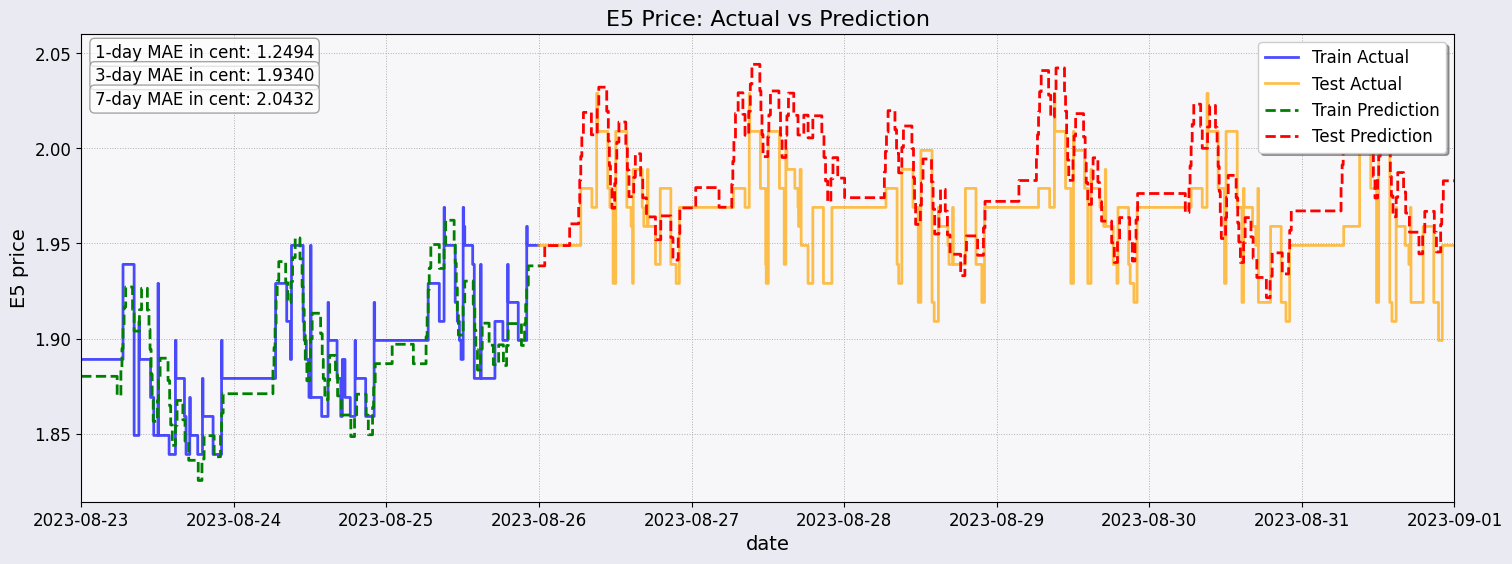

In [6]:
train_plot_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = 2)
train_plot_end = pd.to_datetime(df_train['date'].iloc[-1]) + pd.Timedelta(days = 1)

train_dates_plot = (train_plot_start.strftime('%Y-%m-%d'), train_plot_end.strftime('%Y-%m-%d'))
test_dates_plot = (forecast_start_date.strftime('%Y-%m-%d'), forecast_end_date.strftime('%Y-%m-%d'))

prophet_pred_plot = forecast[['ds', 'yhat']].copy()
prophet_pred_plot = prophet_pred_plot.rename(columns={'ds': 'date', 'yhat': 'e5'})
prophet_pred_plot['date'] = pd.to_datetime(prophet_pred_plot['date'])

plot_forecast(df_train, df_test, None, prophet_pred_plot, prophet_pred_plot, train_dates_plot, test_dates_plot)
plt.xlim(pd.to_datetime(train_dates_plot[0]),pd.to_datetime(test_dates_plot[1]))